# Explore convection patterns on countably small discrete grid 
### with fixed area coverage of discrete updrafts 

Rank-sort probability $P_w$ to place exactly 4 discrete Boolean updrafts in a 4x4 grid. Those can have 16x15x14x13 = 43680 configurations. Many of these are redundant, just transposed or rotated for instance. 31 stand out based on the mean horizontal divergent wind speed on the grid, and the variance in the number of face-neightbors (not diagonal neighbors). 

In a time-iteration game, define a transition probability with W,R,E,F parameters as: 

`Pw(x,y, t+1) = W w(x,y, t) + R Noise + E N4neigh(x,y, t) + F |V(x,y, t)|`

Pure W gives a diagonal TPM, totally stuck from initial conditions. Pure R makes an unconditional result, categorized by how numerous the equivalency classes are. E and F are pattern-conditional terms, which might lead into persistent forms of organization, whether stationary or propagating or oscillating or perhaps chaotically transitioning? Only a computer can tell us, as [Wolfram](https://atlas.wolfram.com/01/01/) in the unsolvability of even 1D has shown! Safe from analytic mathematicians and their scowls at how much we didn't learn formally... :) 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.ndimage import label, generate_binary_structure
import pandas as pd
from pandas.plotting import scatter_matrix
from scipy.signal import convolve2d # to find n_neighbors 
import gif 
from IPython.display import Image

In [2]:
# Functions for plotting, n_neighbors, labelcount (#blobs)

def tileplot(arr,N=2, **kwargs): 
    plt.figure( figsize=(2,2))
    plt.pcolormesh( np.tile(arr, (N, N)), cmap='RdBu_r', shading='nearest', \
                    vmin=-np.max(np.abs(arr)),vmax=np.max(np.abs(arr)), **kwargs);
    
def tilepcolor(arr,N=2, NLEV=23, **kwargs): 
    plt.pcolormesh( np.tile(arr, (N, N)), shading='nearest',**kwargs);

def tilecon(arr,N=2, NLEV=23, **kwargs): 
    plt.contourf( np.tile(arr, (N, N)), cmap='RdBu_r',levels=NLEV, **kwargs);
      
def tilequiv(u,v,N=2, pivot='mid', **kwargs): 
    plt.quiver( np.tile(u, (N, N)), np.tile(v, (N, N)), **kwargs);

def labelcount (arr,N=2, **kwargs): 
    return label( np.tile(arr, (N, N)), **kwargs)[1]

def labelcount_diag (arr,N=2, **kwargs): 
    s = generate_binary_structure(2,2)
    return label( np.tile(arr, (N, N)), structure=s, **kwargs)[1]

def n_neighbors(w, max=4):
    # default case: 4 neighbors
    kernel = np.array([
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0]      ])
    if (max==8): 
        kernel = np.ones((3, 3)); kernel[1, 1] = 0  # Exclude the center cell itself
    if (max==9): 
        kernel = np.ones((3, 3))
   
    # Apply the convolution
    neigh = convolve2d(w, kernel, mode='same', boundary='wrap')
    return(neigh)

In [3]:
# Fourier transform of w returns what, Chi, u, v

def what_Chi_u_v(w):
    
    what = np.fft.fft2(w-np.mean(w))  # Subtract the mean 
    ky, kx = np.fft.fftfreq(w.shape[0]), np.fft.fftfreq(w.shape[1])
    ky2,kx2 = np.meshgrid(ky, kx, indexing='ij')
    kk2 = np.sqrt(kx2**2 + ky2**2)
    
    Chi = np.fft.fft2 (what / (kk2+1e-9)) # Division by zero avoided, only occurs for what=0
    
    Chi = np.roll( np.flipud( np.fliplr(Chi)) ,(1,1),axis=(0,1))  # Graphical fix! Kangfirmed!
    
    # Adjust the boundaries for periodicity and compute gradient, then trim it 
    Chi_padded = np.pad(Chi.real, ((1, 1), (1, 1)), mode='wrap')
    grad_x, grad_y = np.gradient(Chi_padded)
    v = grad_x[1:-1, 1:-1]
    u = grad_y[1:-1, 1:-1]
    
    # KE once we trust it 
    KE = (u**2 + v**2)/2

    return what,Chi,u,v

In [10]:
NX = 4; NCELLS = 4

dfus = pd.read_json('df_uniq_sort.4in4x4.100000.json')  # kangfirmed it works
NSAMP=100000
dfus.Nconfigs.sum()

np.int64(100000)

/Users/bmapes/.local/share/mamba/envs/hk25/lib/python3.12/site-packages/matplotlib/quiver.py:695: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Users/bmapes/.local/share/mamba/envs/hk25/lib/python3.12/site-packages/matplotlib/quiver.py:695: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


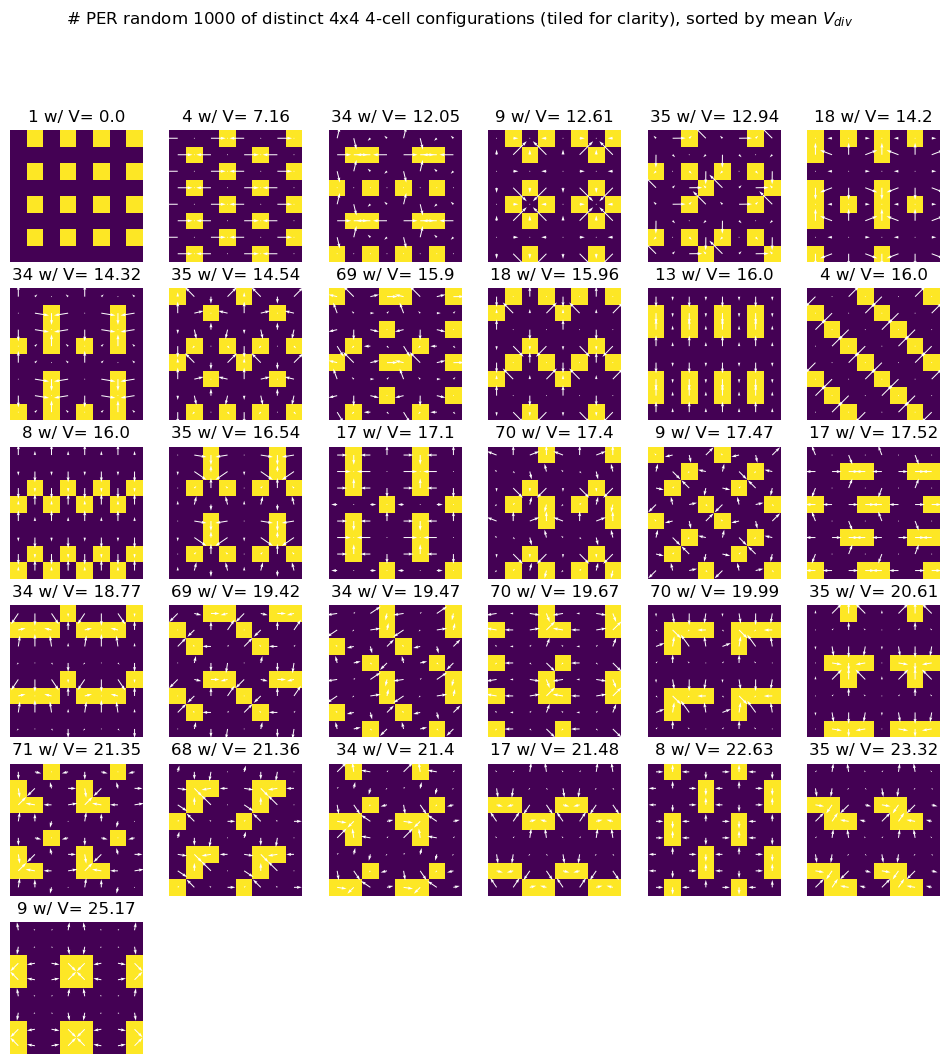

In [11]:
# Display unique configurations 
plt.figure( figsize=(12,12) )
plt.suptitle('# PER random 1000 of distinct 4x4 4-cell configurations (tiled for clarity), sorted by mean $V_{div}$');

for index, row in dfus.iterrows():
    plt.subplot(6,6,index)
    tilepcolor(row['w']); tilequiv(row.u, row.v, color='white')
    plt.axis('off'); 
    # Title: meanV 
    plt.title( str( int(row.Nconfigs *1000/NSAMP) )+' w/ V= '+str( np.round(row.MeanV,2) ) );

## Ensemble exps of time transitions
#### at time t, local cell probability of getting a next-time w (top 4 of P_w): 

$P_w(x,y, t+1) = W \cdot w(x,y, t) + R \cdot Noise + E \cdot N_{4neigh}(x,y, t) + F \cdot |V(x,y, t)|$

1. Construct a function Pw(x,y, t+1; W,R,E,F)
2. Initialize 4 w=1 cells randomly, and iterate for “many” time steps
3. Collect transitions in TPM, & time series for fixed points or cycles
4. Repeat step 2. a few times to test I.C.-robustness of results 

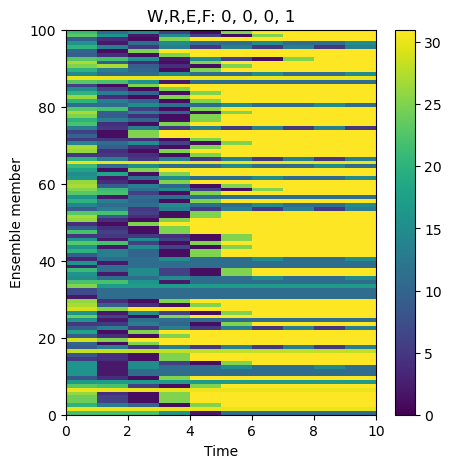

In [439]:
# Ensemble experiment controller: W,R,E,F parameters zero, unless set otherwise 

W=0  # persistence effect  
E=0  # Entrainment, favors neighbor-protected (clumps?) 
F=1  # Windspeed, favors wind-making patterns (gaps? lines?)
R=0  # Randomness, helps keep local optima from locking in 

expname='W=0,E=0,R=0,F=1'

NT = 10      # Time steps from random initialization 
NENS = 100   # Number of random initializations
gif_flag = False 

# What stats to collect? 
configs = np.zeros((NENS,NT)) # configs is time series of the index number
meanVs  = np.zeros((NENS,NT))
meanN4s = np.zeros((NENS,NT)) # number of face neighbors 
varN4s  = np.zeros((NENS,NT)) # number of face neighbors 
meanN8s = np.zeros((NENS,NT)) # number of diagonal neighbors 
Nblobss = np.zeros((NENS,NT))
Nblobsds= np.zeros((NENS,NT))
ws = []   # list OF w ARRAYS 
us = []   # list OF w ARRAYS 
vs = []   # list OF w ARRAYS 

# collect tiled image frames in a gif
frames = []  # one giant gif, for perusing not playing
@gif.frame
def plot_gif_frame(i,titstring):
    tilepcolor(w); tilequiv(u, v, color='white'); plt.colorbar(); plt.axis('off')
    plt.title(titstring);

# Ensemble loop of time loops 
for iens in range(NENS): 
    # print(iens)
    # Initialize randomly this initial ensemble member 
    w = np.zeros((NX,NX))
    # w.ravel()[np.random.choice(NX*NX, NCELLS, replace=False)] = 1 # old direct way

    P_w = np.random.uniform(size=(4, 4))  # probability values are uniform in [0,1] 
    w[np.unravel_index(np.argpartition(P_w, -4, axis=None)[-4:], w.shape)] = 1    
    for it in range(NT): 
        # At each time, compute stats of the present w pattern 

# 2D impications of the pattern of w=1 cells 
        what,Chi,u,v = what_Chi_u_v(w)
        WS = np.sqrt(u**2 + v**2)
        KE = (WS**2)/2 # array
        N4 = n_neighbors(w, max=4)         # N4 is square cell faces only 
        N8 = n_neighbors(w, max=8)         # N8 counts diagonal neighbors too 

# Single number stats characterizing the whole pattern 
        meanV = np.mean(WS)
        varN4 = np.mean(N4**2)
        Nblobs =labelcount(w,4)/16.        # Mean number of blobs in 4-tiled version, a discriminator
        Nblobsd=labelcount_diag(w,4)/16.   # Mean number of diag blobs in 4-tiled version, a discriminator

# Characterize the w array by its index number in df_uniq_sort (dfus file from disk)
        
# Using the index labeling code (meanWS + 1/100 varN4)
        meanVplusvarN4 = np.round(np.mean(WS) + np.array(varN4)/100.,6)
        index_value = (dfus[dfus['MeanVpN2neigh'] == meanVplusvarN4].index) .values[0]
        
# Collect stats in output arrays 
        meanVs  [iens,it] = meanV 
        Nblobss [iens,it] = Nblobs 
        Nblobsds[iens,it] = Nblobsd
        meanN4s [iens,it] = np.mean(N4)
        varN4s  [iens,it] = varN4
        meanN8s [iens,it] = np.mean(N8) 
        configs[iens,it]  = index_value
        ws.append(w)
        us.append(u)
        vs.append(v)
        
# Capture a gif frame if desired (slow) 
        if gif_flag: 
            titstring = str((iens)*NT+it)+', state= '+str(index_value)
            frames.append( plot_gif_frame(it, titstring) ) 
        
    # Clear the w field, define P_w the probability, and build the next state 
        w = np.zeros((NX,NX))
        Noise = np.random.uniform(size=(4, 4))  # Fresh each time, uniform in [0,1] 
        P_w = W*w + R*Noise + E*N4 + F*WS

        # Next w pattern for loop: w=1 for 4 most probable sites         
        # Set the four largest values of P_w to 1, efficiently. Yes I tested it.  
        w[np.unravel_index(np.argpartition(P_w, -4, axis=None)[-4:], w.shape)] = 1

# Time and ensemble loop done. Plot the results 

# Put the results a pandas dataframe 
dfens = pd.DataFrame({
    'config': (configs).ravel() ,  
    'MeanV': np.round( (meanVs).ravel() ,4) ,  
    'varN4s': (varN4s).ravel() ,
    'MeanVpN2neigh': np.round(meanVs.ravel() + varN4s.ravel()/100.,6),
    'w': ws,  # No 2D indexing, just a list in order of computation 
    'u': us,
    'v': vs,
})


plt.figure( figsize=(5,5) )
plt.pcolormesh((configs), vmin=0, vmax=31); plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Ensemble member')
#plt.ylim([0,31]); plt.ylabel('Config #, sorted by mean |V|' );  # from pre-ensemble code history
plt.title('W,R,E,F: '+str(np.round(W,2))+', '+str(np.round(R,1))+', '+str(np.round(E,1))+', '+str(np.round(F,1)));
plt.savefig('Ens-t_'+expname+'.png')

if gif_flag: 
    gif.save(frames, 'anim.gif', duration=500)
    Image(filename='anim.gif')
    !open anim.gif

Text(0.5, 1.0, 'Ensemble config numerosity, compared to random')

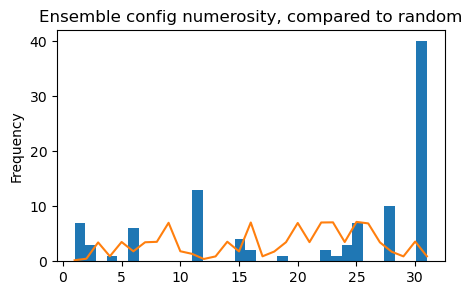

In [437]:
plt.figure( figsize=(5,3) )
dfens.config.plot.hist(bins=33);
plt.plot(np.arange(31)+1, dfus.Nconfigs *dfens.config.size/NSAMP );
plt.title('Ensemble config numerosity, compared to random')

In [425]:
# Unique configurations dfensu, sorted is dfensus
dfensu = dfens.drop_duplicates(subset=['config']).merge(
    dfens['config'].value_counts().reset_index(name='Nconfig'),
    on='config',
    how='left')
dfensus= dfensu.sort_values("MeanV")
# reindex  
dfensus.index = np.arange(1, len(dfensus) + 1)

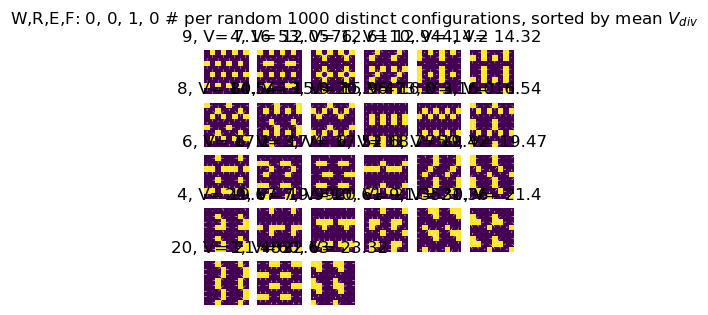

In [426]:
# Display unique configurations 
plt.figure( figsize=(4,4) )

plt.suptitle('W,R,E,F: '+str(np.round(W,2))+', '+str(np.round(R,1))+', '+str(np.round(E,1))+', '+str(np.round(F,1)) +\
            ' # per random 1000 distinct configurations, sorted by mean $V_{div}$');

for index, row in dfensus.iterrows():
    plt.subplot(6,6,index)
    tilepcolor(row['w']); tilequiv(row.u, row.v, color='white')
    plt.axis('off'); 
    # Title: meanV 
    plt.title( str( int(row.Nconfig*1000/NT/NENS) )+', V= '+str( np.round(row.MeanV,2) ) );

/var/folders/8f/r03vpksx46l5r53nhvpfywtc0000gn/T/ipykernel_95036/2284947255.py:14: RuntimeWarning: invalid value encountered in divide
  TPM[:,icol] = TC[:,icol]/np.sum(TC[:,icol])


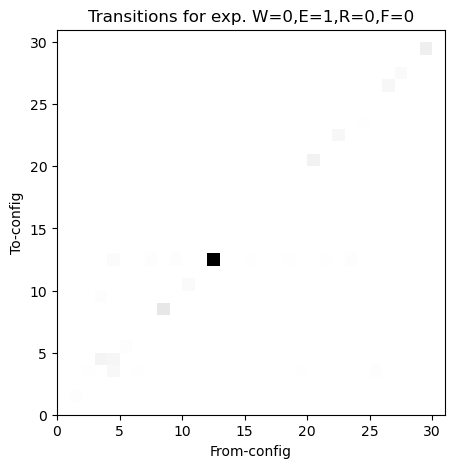

In [427]:
# TPMs from ensemble outputs 
TC = np.diag( dfus.Nconfigs )*0.0 # Right size (31x31)
TPM = np.diag( dfus.Nconfigs )*0.0 # Right size (31x31)

# Transition COUNTS (TC) 
for iens in range(NENS): 
    for it in range(NT-1): 
        fromconfig = int(configs[iens,it])-1
        toconfig   = int(configs[iens,it+1])-1
        TC[toconfig,fromconfig] += 1.0      # Python arrays [y,x] in pcolormesh terms 

# Normalize each column to a TPM probability (sums to 1)
for icol in range(dfus.index.size): 
    TPM[:,icol] = TC[:,icol]/np.sum(TC[:,icol])

plt.figure( figsize=(5,5) )
#plt.contour(np.outer(dfus.Nconfigs,(dfus.Nconfigs)), alpha=0.1) # BACKGROUND: Outer product of random dfus
plt.pcolormesh( TC, cmap='Greys' ); 
#plt.colorbar();
plt.xlabel('From-config'); plt.ylabel('To-config'); 
plt.title('Transitions for exp. '+expname);

#for iens in range(NENS): 
#    plt.plot(configs[iens,0:NT-2],configs[iens,1:NT-1]) # linewidth=np.arange(NT-1)+1 )

#for it in range(NT-1):
#    for iens in range(NENS): 
#        plt.plot(configs[iens,it],configs[iens,it+1])

plt.savefig('TC_'+expname+'.png')

In [ ]:
# Example from Gemini of houw to count redundant configs 

import pandas as pd
# Sample DataFrame (replace with your actual DataFrame)
data = {'id': [1, 2, 3, 4, 5, 6, 7],
        'T': ['apple', 'banana', 'cherry', 'apple', 'date', 'fig', 'banana'],
        'value': [10, 20, 30, 40, 50, 60, 70]}
df = pd.DataFrame(data)

# Solution
df_result = df.drop_duplicates(subset=['T']).merge(
    df['T'].value_counts().reset_index(name='T_redundancy_count'),
    on='T',
    how='left'
)

print(df_result)